# Example of phenotypic clustering

This notebook exemplifies some steps involved in working with annotations from the IDR. It will build a figure similar to the Figure 1.b of the paper from Rohn et al. "Comparative RNAi screening identifies a conserved core metazoan actinome by phenotype" (IDR008).

### Dependencies

 * [Matplotlib](http://matplotlib.org/)
 * [NumPy](http://www.numpy.org/)
 * [Pandas](http://pandas.pydata.org/)
 * [SciPy](https://www.scipy.org/)
 * [Seaborn](https://seaborn.pydata.org/)


In [1]:
import os
import sys
import random
import omero

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hchy

from seaborn import clustermap
from pandas import Series
from pandas import DataFrame
from pandas import read_csv
from pandas import merge,concat
from pandas import read_hdf,HDFStore
from idr import connection

#%matplotlib nbagg
%matplotlib inline
plt.rcParams['image.cmap']='gray'

### Common variables

In [2]:
screenId = 206

### Method definitions

In [3]:
def buildComposite(st, n, m, smpl=None):
    """
    nxm shots from st in a grid, as an image
    """
    nr = st.shape[0]
    nc = st.shape[1]
    if smpl == None:
        smpl = st.shape[2]/(n*m)
    res = np.zeros((nr*n,nc*m))
    for i in range(n):
        for j in range(m):
            try:
                res[i*nr:i*nr+nr,j*nc:j*nc+nc]=st[:,:,(i*m+j)*smpl]
            except:
                break
    return res

In [4]:
def getRohnTile(imid, x, y, w, h, conn, chan=0):
    """
    fetches one tile from one image
    """
    im = conn.getObject("Image", imid)
    pix = im.getPrimaryPixels()

    z=0
    c=chan
    tile = (x, y, w, h) 
    plane = pix.getTile(theC=c, tile=tile)
    
    return plane

In [5]:
# %load ../library/getBulkAnnotationAsDf.py
def getBulkAnnotationAsDf(screenID, conn):
    ofId = None
    sc = conn.getObject('Screen', screenID)
    for ann in sc.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            if (ann.getFile().getName() == 'bulk_annotations'):
                if (ann.getFile().getSize()> 1476250900): #about 140Mb?
                    print "that's a big file..."
                    return None
                ofId = ann.getFile().getId()
                break

    if ofId is None:
        return None

    original_file = omero.model.OriginalFileI(ofId, False)

    openTable = conn.c.sf.sharedResources().openTable(original_file)
    rowCount = openTable.getNumberOfRows()

    column_names = [col.name for col in openTable.getHeaders()]

    black_list = []
    column_indices = []
    for column_name in column_names:
        if column_name in black_list:
            continue
        column_indices.append(column_names.index(column_name))

    table_data = openTable.slice(column_indices, None)
    data = []
    for index in range(rowCount):
        row_values = [column.values[index] for column in table_data.columns]
        data.append(row_values)

    dfAnn = DataFrame(data)
    dfAnn.columns = column_names
    return dfAnn

### Connect to the IDR server

In [6]:
conn = connection()
# Downloading the annotation file for the whole screen
# as a panda DataFrame
dfRhonAnn = getBulkAnnotationAsDf(screenId, conn)

### Phenotype clustering

#### A. Transforming phenotypes into one hot booleans

In [7]:
BoolCols=[]
PhenLab=[]
for iphen in range(1,41):
    col='Phenotype '+str(iphen)
    dfRhonAnn['Bool'+col]=~(dfRhonAnn[col] =='')
    BoolCols.append('Bool'+col)
    PhenLab.append(dfRhonAnn[col].unique()[1])

#### B. Performing the hierarchical linkage on the gene with a phenotype

In [8]:
# count a gene as having a phenotype
# if at least one well annotated with
# it has a phenotype
phenMap = dfRhonAnn[dfRhonAnn['Has Phenotype']=='yes'].groupby('Gene Symbol')[BoolCols].sum()>0
phenMap = phenMap[phenMap.sum(axis=1)>0]
phenMap.columns=PhenLab
Z = hchy.linkage(phenMap, 'ward')
Zt = hchy.linkage(phenMap.transpose(), 'ward')


/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


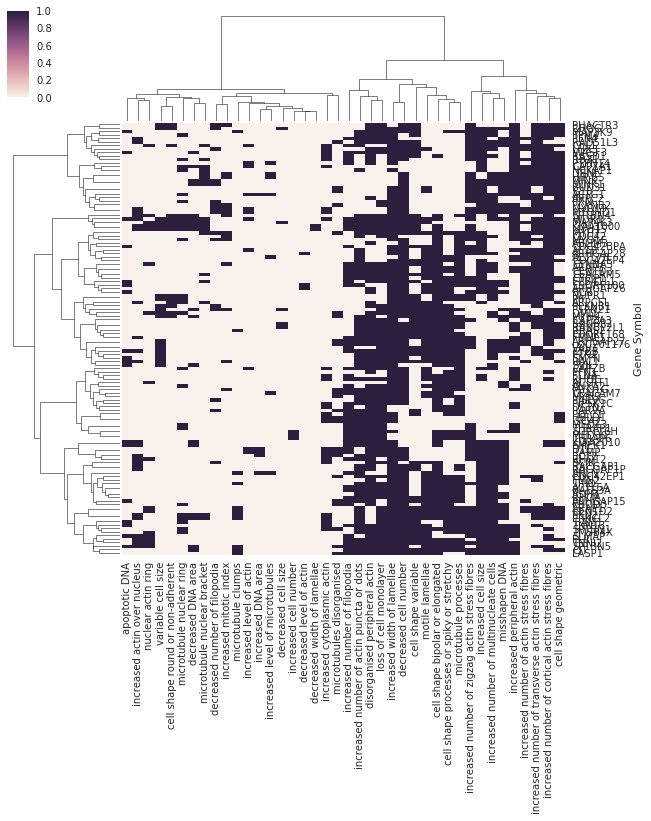

In [9]:
cg = clustermap(phenMap, row_linkage=Z, col_linkage=Zt)
for item in cg.ax_heatmap.get_xticklabels():
    item.set_rotation(90)
for item in cg.ax_heatmap.get_yticklabels():
    item.set_rotation(0)


### Building a gallery of images for visualization

A. Gallery of tiles for a bunch of phenotypes

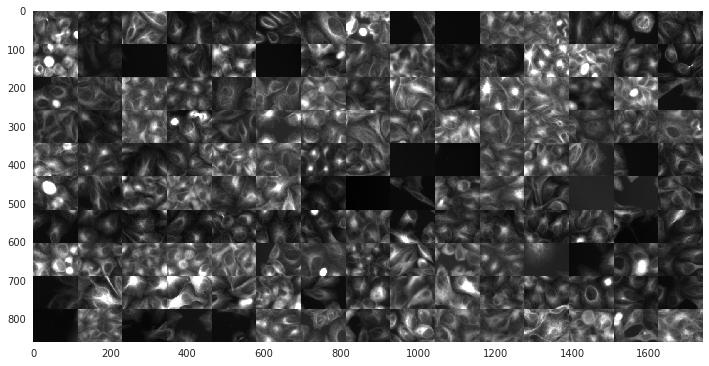

In [10]:
# hard coded, but corresponds to tile size used for CHARM features computation
X=[  0, 580, 116, 348, 232, 464]
Y=[  0, 348,  87, 174, 261]
ni=15
w=116
h=86

#some phenotype
phs=range(20,30)

tiles=np.zeros((h,w,len(phs)*ni))
for kk,ph in enumerate(phs):
    #print ph
    ws=dfRhonAnn[dfRhonAnn['Phenotype '+str(ph)]!=''].Well
#    ws=dfRhonAnn[dfRhonAnn['BoolPhenotype '+str(ph)]].Well
    for ii in range(ni):
        we=random.choice(ws.values)
        we=conn.getObject('Well',we)
        i=we.getImage()   
        x=random.choice(X)
        y=random.choice(Y)
        #print x,y,w,h,i.getId()
        tiles[:,:,ii+kk*ni] =getRohnTile(i.getId(),x,y,w,h, conn,chan=1)

plt.figure(figsize=(12,12))
imc=buildComposite(tiles,len(phs),ni)
plt.grid(False)
plt.imshow(imc)
    

### Disconnect when done loading data

In [11]:
conn.close()

### License

Copyright (C) 2016 University of Dundee. All Rights Reserved.

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.